In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [3]:
np.random.seed(500)

In [4]:
df = pd.read_csv(r"dataset_intent_train.csv",sep=';')
print(df)

,question,scenario,intent
0,have i got any alarms set,alarm,query
1,what's the current temperature,weather,query
2,tell me about lisa ann,qa,factoid
3,play jumper by third eye blind,play,music
4,if there any alarm is set then let me know,alarm,query
...,...,...,...
14509,i want to mute the speaker,audio,volume_mute
14510,are there any alarms set what are they,alarm,query
14511,put on some techno music please,play,music
14512,kill all the frogs you see,general,quirky


In [5]:
# Step - a : Remove blank rows if any.
df['question'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
df['question'] = [entry.lower() for entry in df['question']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
df['question']= [word_tokenize(entry) for entry in df['question']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(df['question']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'question_final'] = str(Final_words)

In [6]:
from io import StringIO
col = ['intent', 'question_final']
df = df[col]
df = df[pd.notnull(df['question_final'])]
df.columns = ['intent', 'question_final']
df['category_id'] = df['intent'].factorize()[0]
category_id_df = df[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'intent']].values)
df

,intent,question_final,category_id
0,query,"['get', 'alarm', 'set']",0
1,query,"['current', 'temperature']",0
2,factoid,"['tell', 'lisa', 'ann']",1
3,music,"['play', 'jumper', 'third', 'eye', 'blind']",2
4,query,"['alarm', 'set', 'let', 'know']",0
...,...,...,...
14509,volume_mute,"['want', 'mute', 'speaker']",28
14510,query,"['alarm', 'set']",0
14511,music,"['put', 'techno', 'music', 'please']",2
14512,quirky,"['kill', 'frog', 'see']",10


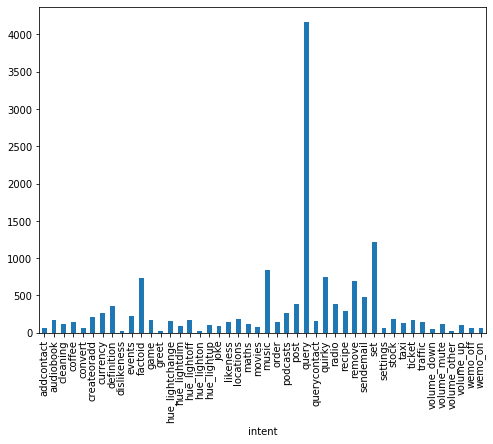

In [7]:
fig = plt.figure(figsize=(8,6))
df.groupby('intent').question_final.count().plot.bar(ylim=0)
plt.show()

In [8]:
#SE NON FUNZIONA RIGUARDA QUESTA PARTE
#DEFAULT PARAMETERS 
#min_df = 5
#norm = '12'
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.question_final).toarray()
labels = df.category_id
features.shape

(14514, 6520)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for intent, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(intent))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'addcontact':
  . Most correlated unigrams:
. add
. contact
  . Most correlated bigrams:
. email contact
. add email
# 'audiobook':
  . Most correlated unigrams:
. resume
. audiobook
  . Most correlated bigrams:
. play audiobook
. audio book
# 'cleaning':
  . Most correlated unigrams:
. cleaner
. vacuum
  . Most correlated bigrams:
. robot vacuum
. vacuum clean
# 'coffee':
  . Most correlated unigrams:
. machine
. coffee
  . Most correlated bigrams:
. coffee machine
. make coffee
# 'convert':
  . Most correlated unigrams:
. zone
. difference
  . Most correlated bigrams:
. change timezone
. time difference
# 'createoradd':
  . Most correlated unigrams:
. add
. list
  . Most correlated bigrams:
. grocery list
. new list
# 'currency':
  . Most correlated unigrams:
. rate
. dollar
  . Most correlated bigrams:
. dollar euro
. exchange rate
# 'definition':
  . Most correlated unigrams:
. definition
. define
  . Most correlated bigrams:
. look like
. definition word
# 'dislikeness':
  . Mos

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['question_final'], df['intent'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
#EXAMPLE OF PREDICTION 1
print(clf.predict(count_vect.transform(["delete item on list"])))

['remove']


In [12]:
#EXAMPLE OF PREDICTION 2
print(clf.predict(count_vect.transform(["what brand hair spray does donald trump use"])))

['query']


In [14]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/pietro/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/pietro/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

In [15]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.776423
LogisticRegression        0.730880
MultinomialNB             0.582403
RandomForestClassifier    0.287033
Name: accuracy, dtype: float64

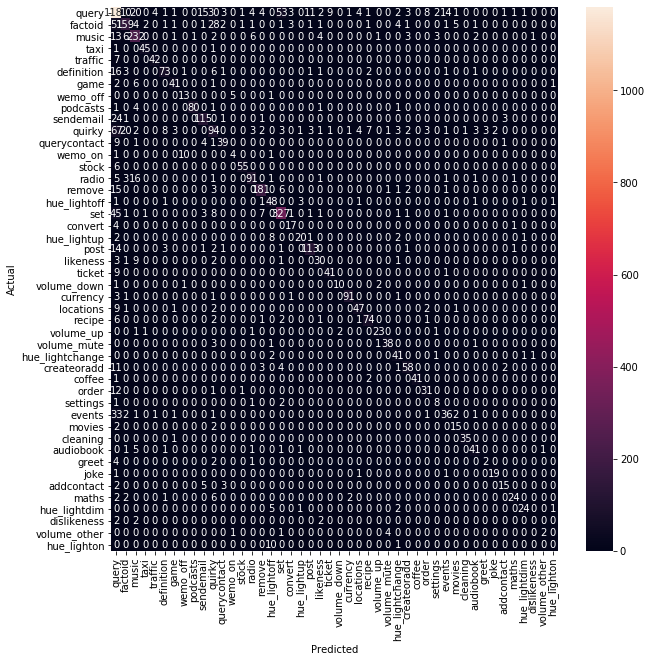

In [16]:
import seaborn as sns
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.intent.values, yticklabels=category_id_df.intent.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['intent', 'question']])
      print('')

'factoid' predicted as 'query' : 51 examples.


KeyError: "['question'] not in index"

In [ ]:
model.fit(features, labels)
N = 2
for intent, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(intent))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['intent'].unique()))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['question_final'], df['intent'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
svc = LinearSVC().fit(X_train_tfidf, y_train)

In [ ]:
print(svc.predict(count_vect.transform(["delete item on list"])))

In [ ]:
print(svc.predict(count_vect.transform(["what brand hair spray does donald trump use"])))

In [ ]:
df_test = pd.read_csv(r"testset_notarget.csv", sep=',')
df_test

In [ ]:
target = []
for row in df_test['question']:
    target.append(svc.predict(count_vect.transform([row])))
df_test['intent'] = target
df_test